# Assignment 3

## *Generating useful features for further analysis on Amazon reviews*
<h2>Introduction</h2>
<p><strong>Business Context.</strong> You are a business consultant with new clients that are interested in analyzing reviews of their products on Amazon (as opposed to Yelp). They want to answer business questions like: "What are the most important factors driving negative reviews?", "Have there been any large changes to customer satisfaction/reviews over time?", etc.</p>
<p><strong>Business Problem.</strong> Your main task is to <strong>explore the given data and use the results of your investigation to engineer relevant features that could facilitate subsequent analysis and model-building</strong>.</p>
<p><strong>Analytical Context.</strong> The dataset provided is a large body of reviews related to movies and television left on Amazon between 1996 and 2014. When exploring our dataset, we will quickly encounter a familiar problem we discussed in the previous case: the word "good" is one of the most important words in both positive <em>and</em> negative reviews. Thus, we must develop methods to put "good" in the appropriate context.</p>

<h2>Loading the data</h2>
<p>We use a dataset of around 37,000 video reviews from Amazon Instant Video and 1,700,000 movie and TV reviews, all obtained from the website: http://jmcauley.ucsd.edu/data/amazon/. Note that there are much larger datasets available at the same site. We can expect better and more consistent results on larger datasets (such as book reviews). Note that these datasets are compressed (gzipped), and they are in <a href="https://en.wikipedia.org/wiki/JSON">JSON</a> format, with each line representing a review and each line being its own JSON object.</p>
<p>We begin by loading the dataset below:</p>

In [1]:
%matplotlib inline

In [33]:
%%time
import gzip
import json
import string
import re

import nltk # imports the natural language toolkit
import pandas as pd
import plotly

from collections import Counter
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('punkt')


# we can tell pandas that our file is in gzip format and it will handle the decompression for us
# we also use `lines=True` to indicate that each line of the file is its own JSON object
instant_video = pd.read_json("reviews_Amazon_Instant_Video_5.json.gz", lines=True, compression='gzip')


# ----------
# The Movies and TV file is very big. If you have problems loading it, you can load only the first 
# 100,000 reviews by using 'chunksize' (uncomment the line with 'chunksize' and comment out the line 
# after that which loads the entire file into `movies_tv`). All of the analysis can be 
# done in the same way using only the subset of reviews but some of the results might be different from the examples.
# ----------
movies_tv = next(pd.read_json("reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip', chunksize=10000))
#movies_tv = pd.read_json("reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Karuna\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Wall time: 3.27 s


<h2>Examining the data</h2>
<p>We take a look at the first 5 rows of each dataset to see what attributes are available. These are</p>
<ul>
<li><strong>reviewerID:</strong> A unique ID to identify the author of the review.</li>
<li><strong>asin:</strong> The <a href="https://www.amazon.com/gp/seller/asin-upc-isbn-info.html">"Amazon Standard Identification Number"</a> which provides more information about the exact product and version.</li>
<li><strong>reviewerName:</strong> The username chosen by the reviewer.</li>
<li><strong>helpful:</strong> A record of how many users indicated that the review was helpful/not helpful.</li>
<li><strong>reviewText:</strong> The full text of the review.</li>
<li><strong>overall:</strong> The overall rating (1-5) left by the reviewer.</li>
<li><strong>summary:</strong> A short version of the review, used as the title.</li>
<li><strong>unixReviewTime:</strong> The date that the review was created, in <a href="https://en.wikipedia.org/wiki/Unix_time">Unix Epoch</a> format.</li>
<li><strong>reviewTime:</strong> A human readable date giving the day, month, and year.
</font></li>
</ul>

In [34]:
print(len(instant_video))
(instant_video.head(5))

37126


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A11N155CW1UV02,B000H00VBQ,AdrianaM,"[0, 0]",I had big expectations because I love English ...,2,A little bit boring for me,1399075200,"05 3, 2014"
1,A3BC8O2KCL29V2,B000H00VBQ,Carol T,"[0, 0]",I highly recommend this series. It is a must f...,5,Excellent Grown Up TV,1346630400,"09 3, 2012"
2,A60D5HQFOTSOM,B000H00VBQ,"Daniel Cooper ""dancoopermedia""","[0, 1]",This one is a real snoozer. Don't believe anyt...,1,Way too boring for me,1381881600,"10 16, 2013"
3,A1RJPIGRSNX4PW,B000H00VBQ,"J. Kaplan ""JJ""","[0, 0]",Mysteries are interesting. The tension betwee...,4,Robson Green is mesmerizing,1383091200,"10 30, 2013"
4,A16XRPF40679KG,B000H00VBQ,Michael Dobey,"[1, 1]","This show always is excellent, as far as briti...",5,Robson green and great writing,1234310400,"02 11, 2009"


In [35]:
print(len(movies_tv))
(movies_tv.head(5))

10000


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,ADZPIG9QOCDG5,0005019281,"Alice L. Larson ""alice-loves-books""","[0, 0]",This is a charming version of the classic Dick...,4,good version of a classic,1203984000,"02 26, 2008"
1,A35947ZP82G7JH,0005019281,Amarah Strack,"[0, 0]",It was good but not as emotionally moving as t...,3,Good but not as moving,1388361600,"12 30, 2013"
2,A3UORV8A9D5L2E,0005019281,Amazon Customer,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3,Winkler's Performance was ok at best!,1388361600,"12 30, 2013"
3,A1VKW06X1O2X7V,0005019281,"Amazon Customer ""Softmill""","[0, 0]",Henry Winkler is very good in this twist on th...,5,It's an enjoyable twist on the classic story,1202860800,"02 13, 2008"
4,A3R27T4HADWFFJ,0005019281,BABE,"[0, 0]",This is one of the best Scrooge movies out. H...,4,Best Scrooge yet,1387670400,"12 22, 2013"


<p>We notice that <code>movies_tv</code> is extremely long with nearly 2 million reviews, and several columns seem uninteresting or hard to work with (e.g. <code>reviewerID</code>, <code>asin</code>, <code>reviewername</code>, <code>reviewtime</code>). We drop some information to make some of our later analysis more efficient. We also add a datetime column with Python datetime objects to more easily summarize the data:</p>

In [36]:
%%time
movies_tv['datetime'] = pd.to_datetime(movies_tv['reviewTime'], format="%m %d, %Y")
instant_video['datetime'] = pd.to_datetime(instant_video['reviewTime'], format="%m %d, %Y")

Wall time: 147 ms


In [37]:
movies_tv = movies_tv.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'reviewTime'])
instant_video = instant_video.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'reviewTime'])

movies_tv.head(5)

,helpful,reviewText,overall,summary,unixReviewTime,datetime
0,"[0, 0]",This is a charming version of the classic Dick...,4,good version of a classic,1203984000,2008-02-26
1,"[0, 0]",It was good but not as emotionally moving as t...,3,Good but not as moving,1388361600,2013-12-30
2,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3,Winkler's Performance was ok at best!,1388361600,2013-12-30
3,"[0, 0]",Henry Winkler is very good in this twist on th...,5,It's an enjoyable twist on the classic story,1202860800,2008-02-13
4,"[0, 0]",This is one of the best Scrooge movies out. H...,4,Best Scrooge yet,1387670400,2013-12-22


In [38]:
instant_video.head()

,helpful,reviewText,overall,summary,unixReviewTime,datetime
0,"[0, 0]",I had big expectations because I love English ...,2,A little bit boring for me,1399075200,2014-05-03
1,"[0, 0]",I highly recommend this series. It is a must f...,5,Excellent Grown Up TV,1346630400,2012-09-03
2,"[0, 1]",This one is a real snoozer. Don't believe anyt...,1,Way too boring for me,1381881600,2013-10-16
3,"[0, 0]",Mysteries are interesting. The tension betwee...,4,Robson Green is mesmerizing,1383091200,2013-10-30
4,"[1, 1]","This show always is excellent, as far as briti...",5,Robson green and great writing,1234310400,2009-02-11


<h3>Exercise 1:</h3>
<h4>1.1</h4>
<p>Plot histograms of all numeric quantities. Do you notice anything interesting about them?</p>

**Answer.**

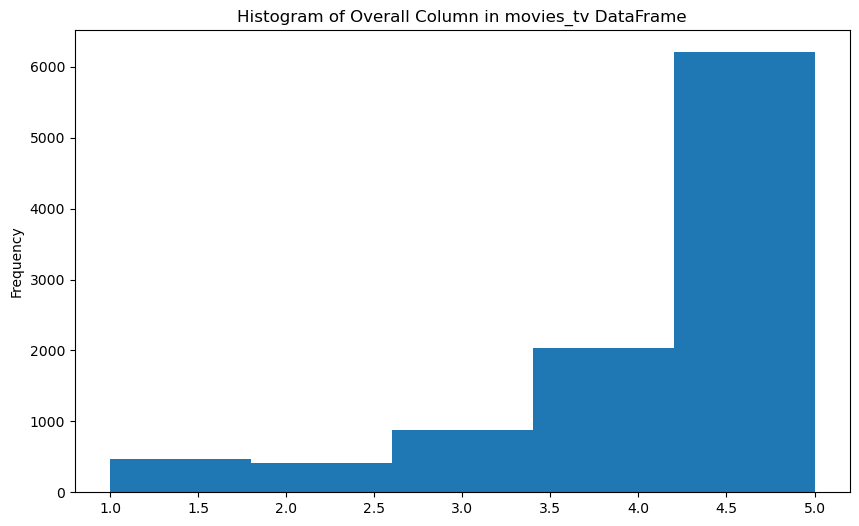

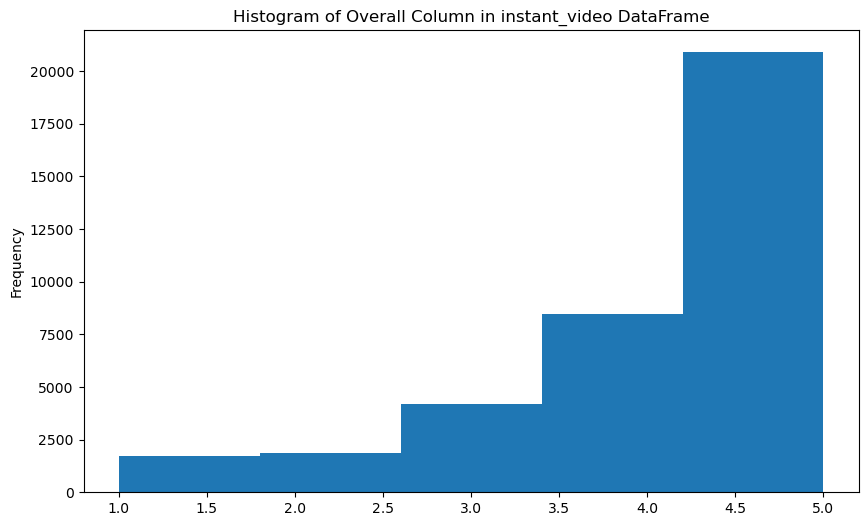

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
movies_tv['overall'].plot(kind='hist', bins = movies_tv['overall'].nunique(), title='Histogram of Overall Column in movies_tv DataFrame')
plt.show()

plt.figure(figsize=(10,6))
instant_video['overall'].plot(kind='hist', bins = instant_video['overall'].nunique(), title='Histogram of Overall Column in instant_video DataFrame')
plt.show()

---

**It's clearly noticeable that people gave a lot more 5 star reviews than any other option.**

---

<h4>1.2</h4>
<p>How do average ratings change over time? Plot the average rating for each year and note any trends.</p>

**Answer.**

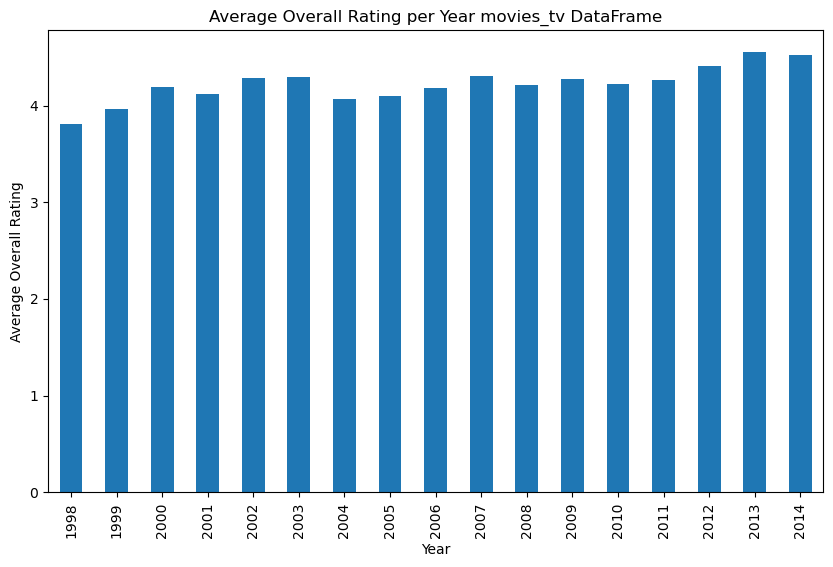

In [40]:
# Extract year from 'datetime' column
movies_tv['year'] = movies_tv['datetime'].dt.year

# Group by year and calculate average of 'overall' column
average_overall_per_year = movies_tv.groupby('year')['overall'].mean()

# Plot the results in a bar plot
plt.figure(figsize=(10,6))
average_overall_per_year.plot(kind='bar', title='Average Overall Rating per Year movies_tv DataFrame')
plt.xlabel('Year')
plt.ylabel('Average Overall Rating')
plt.show()

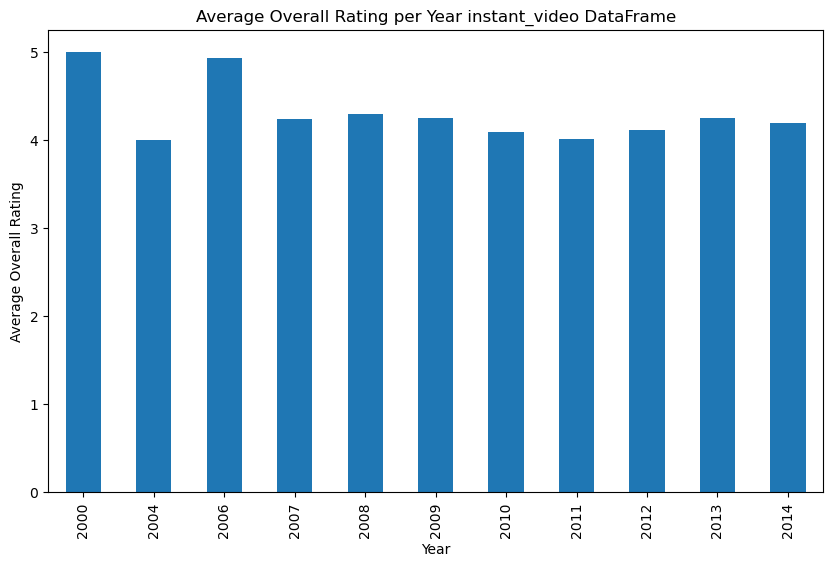

In [41]:
# Extract year from 'datetime' column
instant_video['year'] = instant_video['datetime'].dt.year

# Group by year and calculate average of 'overall' column
average_overall_per_year_instant_video = instant_video.groupby('year')['overall'].mean()

# Plot the results in a bar plot
plt.figure(figsize=(10,6))
average_overall_per_year_instant_video.plot(kind='bar', title='Average Overall Rating per Year instant_video DataFrame')
plt.xlabel('Year')
plt.ylabel('Average Overall Rating')
plt.show()

---

**Not really any noticeable trends, but I think the reviews have gotten lower every year, meaning people are being more critical with their reviews.**

---

<h4>1.3</h4>
<p>Look at the average length of the review by year. Do you notice any trends?</p>

**Answer.**

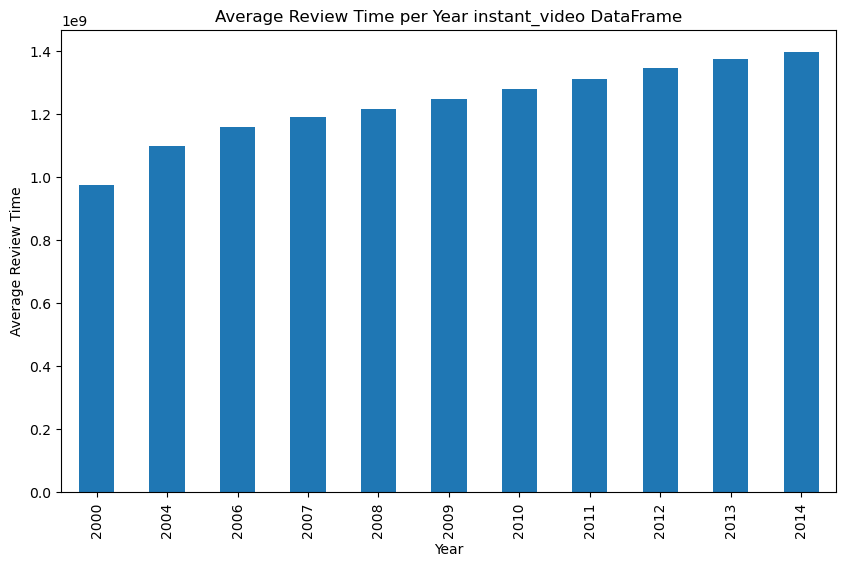

In [42]:
# Group by year and calculate average of 'unixReviewTime' column
average_len_reviewtime_per_year_instant_video = instant_video.groupby('year')['unixReviewTime'].mean()

# Plot the results in a bar plot
plt.figure(figsize=(10,6))
average_len_reviewtime_per_year_instant_video.plot(kind='bar', title='Average Review Time per Year instant_video DataFrame')
plt.xlabel('Year')
plt.ylabel('Average Review Time')
plt.show()

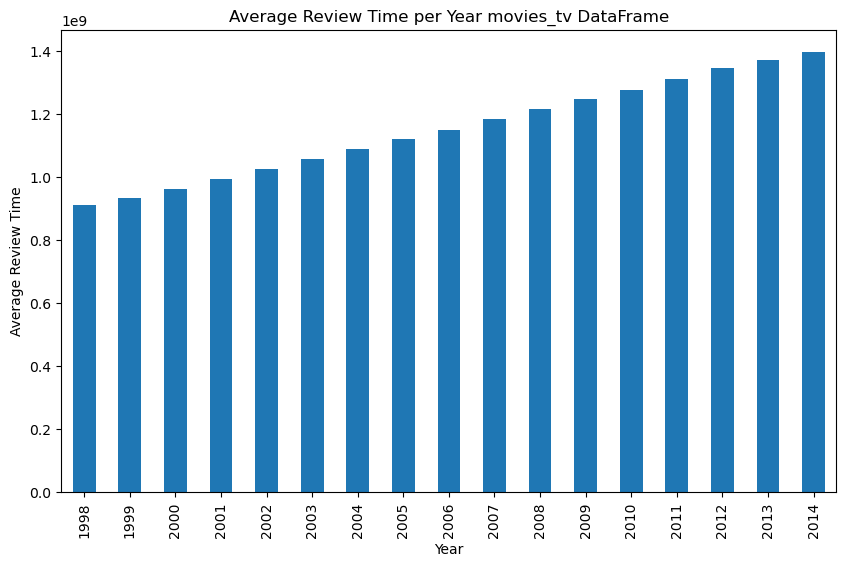

In [43]:
# Group by year and calculate average of 'unixReviewTime' column
average_len_reviewtime_per_year = movies_tv.groupby('year')['unixReviewTime'].mean()

# Plot the results in a bar plot
plt.figure(figsize=(10,6))
average_len_reviewtime_per_year.plot(kind='bar', title='Average Review Time per Year movies_tv DataFrame')
plt.xlabel('Year')
plt.ylabel('Average Review Time')
plt.show()

---

**There's definitley a trend here, people are taking a longer time to give their reviews, again indicating that they're being more thoughtful and critical with their reviews.**

---

<h3>Exercise 2:</h3>
<h4>2.1</h4>
<p>Find the ten most frequently occuring non-stop words acrooss: (i) all reviews, (ii) positive reviews, (iii) negative reviews. Do the results surprise you? Why or why not?</p>

**Answer.**

In [104]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from collections import Counter

nltk.download('stopwords')

# Load stop words
stop_words = set(stopwords.words('english'))
pattern = r"[^\w]"

# Combining reviews from both dataframes 
all_reviews = pd.concat([movies_tv['reviewText'], instant_video['reviewText']], ignore_index=True)

# Count words in positive reviews (overall >=4)
positive_reviews = pd.concat([movies_tv[movies_tv['overall'] >= 4]['reviewText'], instant_video[instant_video['overall'] >= 4]['reviewText']], ignore_index=True)

# Count words in negative reviews (overall <= 3)
negative_reviews = pd.concat([movies_tv[movies_tv['overall'] <= 2]['reviewText'], instant_video[instant_video['overall'] <= 2]['reviewText']], ignore_index=True)

def top_words(review):
    non_stop = []
    words = ''.join(review).lower()
    words = re.sub(pattern, " ", words)
    words = nltk.word_tokenize(words)
    
    for word in words:
        if word not in stop_words:
            non_stop.append(word)
    mostcommon = Counter(non_stop)
    return mostcommon

# Get the top 10 words for each category
top10_all = top_words(all_reviews).most_common(10)
top10_positive = top_words(positive_reviews).most_common(10)
top10_negative = top_words(negative_reviews).most_common(10)

print("Top 10 words in all reviews (movies_tv & instant_video):")
print(top10_all)
print('\n')
print("Top 10 words in positive reviews (movies_tv & instant_video):")
print(top10_positive)
print('\n')
print("Top 10 words in negative reviews: (movies_tv & instant_video)")
print(top10_negative)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Karuna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top 10 words in all reviews (movies_tv & instant_video):
[('show', 26360), ('one', 22896), ('movie', 21047), ('like', 19567), ('film', 17405), ('season', 17106), ('good', 16836), ('great', 14831), ('series', 14209), ('really', 11957)]


Top 10 words in positive reviews (movies_tv & instant_video):
[('show', 21267), ('one', 17453), ('movie', 14904), ('season', 14441), ('like', 13847), ('great', 13165), ('good', 12946), ('film', 12353), ('series', 12031), ('love', 10416)]


Top 10 words in negative reviews: (movies_tv & instant_video)
[('movie', 3169), ('like', 2714), ('one', 2557), ('show', 2320), ('film', 2294), ('would', 1736), ('good', 1490), ('really', 1478), ('34', 1443), ('even', 1318)]


---

**I don't think the results are really too surprising here, all the most common words are movies and tv show related and adjectives like good and great are related to reviewing the movie or tv show so these words make sense.**

---

<h4>2.2</h4>
<p>Find words that are indicative of bad reviews. That is, words that appear often in bad reviews and <em>not</em> in good reviews. What are these words and are they surprising?</p>

**Answer.**

In [105]:
def top_words_noncount(review):
    non_stop = []
    words = ''.join(review).lower()
    words = re.sub(pattern, " ", words)
    words = nltk.word_tokenize(words)
    
    for word in words:
        if word not in stop_words:
            non_stop.append(word)
    return non_stop
neg_most_common = top_words_noncount(negative_reviews)
pos_most_common = top_words_noncount(positive_reviews)

# Get the sets of words from the dictionaries
neg_words_set = set(neg_most_common)
pos_words_set = set(pos_most_common)

# Find the most common words in neg_most_common that are not in pos_most_common
common_words_only_in_neg = neg_words_set - pos_words_set

neg_indicator = []

for word in neg_most_common:
    if word in common_words_only_in_neg:
        neg_indicator.append(word)

In [106]:
Counter(neg_indicator).most_common(50)

[('niken', 20),
 ('java', 11),
 ('raymer', 9),
 ('hedges', 9),
 ('lilo', 8),
 ('claptrap', 7),
 ('turgid', 7),
 ('area_407', 7),
 ('michod', 7),
 ('achmed', 6),
 ('redmayne', 6),
 ('rubia', 6),
 ('pasolini', 5),
 ('denier', 5),
 ('infomercial', 5),
 ('bront', 5),
 ('snoozer', 5),
 ('afterglow', 5),
 ('faerie', 5),
 ('nephilim', 5),
 ('diehl', 5),
 ('geraghty', 5),
 ('godureaux', 5),
 ('polygamy', 5),
 ('malformed', 4),
 ('masochist', 4),
 ('rheinfelden', 4),
 ('slanted', 4),
 ('jayston', 4),
 ('marsden', 4),
 ('sire', 4),
 ('fakey', 4),
 ('plods', 4),
 ('foree', 4),
 ('stew', 4),
 ('vestibule', 4),
 ('stockman', 4),
 ('supervillains', 4),
 ('hashim', 4),
 ('kretschmann', 4),
 ('clem', 4),
 ('craps', 4),
 ('sensationalist', 3),
 ('perpetuating', 3),
 ('sacraments', 3),
 ('unclean', 3),
 ('dreyer', 3),
 ('disgraceful', 3),
 ('untried', 3),
 ('egotist', 3)]

---

**This list is surprising because it seems that rather than adjectives related to reviewing movies and tv shows the most common words seem to be the names of characters or something. I don't really understand this list or the words I'm not too sure how to interpret this.**

---

<h3>Exercise 3:</h3>
<p>Manually inspect the first 10 negative reviews containing the word "good". What do you notice? How does this suggest we ought to proceed next?</p>

**Answer.**

In [107]:
all_df = pd.concat([movies_tv, instant_video], ignore_index=True)
review_with_good = [review for review in negative_reviews if 'good' in review]

In [108]:
all_df_with_good = all_df[all_df['reviewText'].isin(review_with_good)]
all_df_with_good = all_df_with_good.reset_index(drop=True)

In [109]:
all_df_with_good.head()

,helpful,reviewText,overall,summary,unixReviewTime,datetime,year
0,"[13, 23]","The acting was good, the story was correct, bu...",1,Nakedness not necessary!,1298851200,2011-02-28,2011
1,"[113, 119]",The DVD transfer is pretty good but the scene ...,1,Rudy what have they done!,1134259200,2005-12-11,2005
2,"[15, 19]",ANOTHER American cultural icon from the 60's h...,2,"The ""PC"" police strike AGAIN",1137974400,2006-01-23,2006
3,"[9, 28]",why would mel gibson make a movie that would p...,1,Great! for a movie made by a corporate whore j...,1114300800,2005-04-24,2005
4,"[1, 8]",Viewed: 5/14Rate: 15/14: The Passion of the Ch...,1,A Ridiculous Waste of My Time.,1400284800,2014-05-17,2014


In [112]:
for i in range(10):
    print('\n')
    print(review_with_good[i])



The acting was good, the story was correct, but naked backsides was not necessary.  Also the Potiphers wife did not need to be so very seductive of a naked Joseph. Not a Christian movie.  I felt that even though it was probably portrayed truthfully, Christans do not need to see so explicit a scene.  This should be rated PG 13 at least.


The DVD transfer is pretty good but the scene with Yukon discovering peppermint has been cut.It seems pretty odd to sell a DVD as a restored classic only to leave out the main thing that was to be restored!


ANOTHER American cultural icon from the 60's has beendeemed unacceptable by those who would prefer to seemalice where none exists.Not even Underdog can escape the slings and arrows ofthose with the same mentality as the book-burners of1930's Germany.Why do we allow such obvious Orwellian "Newsspeak" toedit our past? Come on... this IS a cartoon, for Pete'ssake, NOT some social/political statement.Nothing here needs to be edited or "cleaned up". 

---

**From manually going through these reviews it seems as if the word 'good' is used either when they're trying to give a positive about the movie or show before they list the problems or when they're trying to say things like "that the movie did more harm than good" making a comparison sort of.**

---

<h3>Exercise 4:</h3>
<p>Go through the list of bad reviews containing the word "good" that we found in the last question. For each review, extract the following:</p>
<ol>
<li>The first word after "good"</li>
<li>The first word after "good" that is a noun or cardinal</li>
<li>The last word before "good" that is a noun or cardinal</li>
</ol>

**Answer.**

In [114]:
first_words_after_good = []

for review in review_with_good:
    # Split the review into words
    words = review.split()
    
    # Find the index of 'good'
    good_index = words.index('good') if 'good' in words else -1
    
    # If 'good' is found and there is a word after it, add it to the list
    if good_index != -1 and good_index < len(words) - 1:
        first_word_after_good = words[good_index + 1]
        first_words_after_good.append(first_word_after_good)

print("First words after 'good':", first_words_after_good[:50])

First words after 'good': ['but', 'plot', 'cinema', 'and', 'as', 'Christians', 'parts.', 'or', 'and', 'because', 'to', 'review', 'guy.', 'majority', 'and', 'man', 'about', 'film', 'thing', 'music.', 'film-making', 'knowledge', 'box', 'comes', 'life,', 'chance', 'actor', 'example', 'movie', 'things', 'a', 'pacing', 'movie', 'intention,', 'depictions', 'Christians?These', 'Jesus', 'cinema.My', 'as', 'while', 'one', 'HiFi', 'I', 'special', 'is', 'thing', 'is', 'movie', 'things', 'by']


In [115]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Karuna\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Karuna\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [118]:
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet

def get_first_noun_or_cardinal_after_good(review):
    words = word_tokenize(review)
    tagged_words = pos_tag(words)

    good_index = [i for i, (word, pos) in enumerate(tagged_words) if word.lower() == 'good']

    first_noun_or_cardinal = None
    for index in good_index:
        for word, pos in tagged_words[index+1:]:
            if pos.startswith('N') or (pos == 'CD' and word.isdigit()):
                first_noun_or_cardinal = word
                break
        if first_noun_or_cardinal:
            break

    return first_noun_or_cardinal


In [119]:
first_noun_or_cardinal_after_good = []

for review in review_with_good:
    result = get_first_noun_or_cardinal_after_good(review)
    if result:
        first_noun_or_cardinal_after_good.append(result)
print("First Nouns or Cardinals after 'good':", first_noun_or_cardinal_after_good[:50])

First Nouns or Cardinals after 'good': ['story', 'scene', 'evil', 'plot', 'cinema', 'history', 'anyone', 'fan', 'Christians', 'parts', 'benefit', 'scenes.To', 'filmmaker', 'extent', 'review', 'guy', 'majority', 'lots', 'man', 'case', 'film', 'thing', 'music', 'film-making', 'knowledge', 'box', 'it.Fifth', 'life', 'chance', 'while', 'actor', 'example', 'movie', 'things', 'job', 'pacing', 'Jesus', 'intention', 'depictions', 'Christians', 'Mel', 'cinema.My', 'people', 'while', 'one', 'FEATURES', 'GUYS', 'HiFi', 'vhs', 'features']


In [123]:
def get_last_noun_or_cardinal_before_good(review):
    words = word_tokenize(review)
    tagged_words = pos_tag(words)

    good_index = [i for i, (word, pos) in enumerate(tagged_words) if word.lower() == 'good']

    last_noun_or_cardinal = None
    for index in good_index:
        for word, pos in reversed(tagged_words[:index]):
            if pos.startswith('N') or (pos == 'CD' and word.isdigit()):
                last_noun_or_cardinal = word
                break
        if last_noun_or_cardinal:
            break

    return last_noun_or_cardinal

In [125]:
last_noun_or_cardinal_before_good = []

for review in review_with_good:
    result = get_last_noun_or_cardinal_before_good(review)
    if result:
        last_noun_or_cardinal_before_good.append(result)
print("Last Nouns or Cardinals before 'good':", last_noun_or_cardinal_before_good[:50])

Last Nouns or Cardinals before 'good': ['acting', 'transfer', 'Theseare', 'story', 'everything', 'acting', 'damage', 'film', 'practices', 'movie', 'nothing', 'flashbacks', 'symbol', 'pain', 'film', 'Jesus', 'movie', 'corse', 'men', 'conundrums', 'anguish', 'movie', 'riff', 'fare', 'film', 'friend', 'head', 'HIM', 'movie', 'Was', 'Gibson', 'Jesus', 'senseless', 'past', 'Earth', 'bloodbath', 'film', 'claims', 'mankind', 'Jesus', 'movie', 'everyone', 'singers', 'frames', 'DVD-R', 'popping', 'MONSTERS', 'tracks', 'movie', 'quality']


<h3>Exercise 5:</h3>
<p>We have seen that individual words are not always very informative. Look for the most informative bigrams and trigrams, in both positive and negative reviews. Show the most informative bigrams and trigrams and give a brief analysis of the n-grams you identified.</p>

**Answer.**

In [131]:
from nltk.util import ngrams

def top_k_ngrams(word_tokens,n,k):
    
    ## Getting them as n-grams
    n_gram_list = list(ngrams(word_tokens, n))

    ### Getting each n-gram as a separate string
    n_gram_strings = [' '.join(each) for each in n_gram_list]
    
    n_gram_counter = Counter(n_gram_strings)
    most_common_k = n_gram_counter.most_common(k)
    print(most_common_k)

In [136]:
non_stop_positive_words = []
positive_words = ''.join(positive_reviews).lower()
positive_words = re.sub(pattern, " ", positive_words)
positive_words = word_tokenize(positive_words)
for word in positive_words:
    if word not in stop_words:
        non_stop_positive_words.append(word)
print('Top 10 Bigrams: ')
top_k_ngrams(non_stop_positive_words, 2, 10)
print('\n')
print('Top 10 Trigrams: ')
top_k_ngrams(non_stop_positive_words, 3, 10)

Top 10 Bigrams: 
[('love show', 1219), ('one best', 1144), ('season 2', 1092), ('story line', 1068), ('sci fi', 1055), ('great show', 1037), ('first season', 1018), ('blu ray', 935), ('well done', 916), ('season 1', 902)]


Top 10 Trigrams: 
[('air force one', 169), ('one best shows', 154), ('would like see', 150), ('tommy lee jones', 133), ('world war ii', 122), ('wait next season', 119), ('one favorite shows', 114), ('well written well', 111), ('new york city', 111), ('looking forward season', 110)]


In [137]:
non_stop_negative_words = []
negative_words = ''.join(negative_reviews).lower()
negative_words = re.sub(pattern, " ", negative_words)
negative_words = word_tokenize(negative_words)
for word in negative_words:
    if word not in stop_words:
        non_stop_negative_words.append(word)
print('Top 10 Bigrams for Negative Reviews: ')
top_k_ngrams(non_stop_negative_words, 2, 10)
print('\n')
print('Top 10 Trigrams for Negative Reviews: ')
top_k_ngrams(non_stop_negative_words, 3, 10)

Top 10 Bigrams for Negative Reviews: 
[('waste time', 180), ('story line', 124), ('first episode', 120), ('special effects', 118), ('sci fi', 115), ('much better', 104), ('even though', 102), ('looks like', 102), ('mel gibson', 87), ('year old', 80)]


Top 10 Trigrams for Negative Reviews: 
[('really wanted like', 27), ('parental guide f', 22), ('waste time money', 19), ('movies ever seen', 17), ('one worst movies', 15), ('first two seasons', 15), ('wanted like show', 15), ('guide f bomb', 14), ('big bang theory', 13), ('watch another episode', 13)]


<h3>Exercise 6:</h3>
<p>Throughout the above search for informative words, we have seen that unigrams are not enough, but important words (such as "good") are not always next to the informative words that they describe. Devise a method to extract these informative words. Provide a brief description of how you will extract the informative words.</p>

**Answer.**

---

**I think here the best way to go about it is to remove stop words from the good reviews and the bad reviews, and then use the functions from exercise 5**

---

In [147]:
# For negative reviews that contain the word 'good'
non_stop_reviews = []

for review in review_with_good:
    words = ''.join(review).lower()
    words = re.sub(pattern, " ", words)
    words = word_tokenize(words)
    for word in words:
        if word not in stop_words:
            non_stop_reviews.append(word)

In [149]:
for i, word in enumerate(non_stop_reviews):
    if word == 'good' and i < len(non_stop_reviews) - 1:
        word_after_good = non_stop_reviews[i + 1]
        print(f"Word after 'good': {word_after_good}")

Word after 'good': story
Word after 'good': scene
Word after 'good': vs
Word after 'good': plot
Word after 'good': cinema
Word after 'good': history
Word after 'good': anyone
Word after 'good': idolatrous
Word after 'good': one
Word after 'good': christians
Word after 'good': bad
Word after 'good': parts
Word after 'good': filter
Word after 'good': great
Word after 'good': enough
Word after 'good': movie
Word after 'good': enough
Word after 'good': uplifting
Word after 'good': visual
Word after 'good': others
Word after 'good': rather
Word after 'good': shallow
Word after 'good': show
Word after 'good': review
Word after 'good': guy
Word after 'good': majority
Word after 'good': interesting
Word after 'good': man
Word after 'good': feeling
Word after 'good': film
Word after 'good': thing
Word after 'good': music
Word after 'good': thief
Word after 'good': way
Word after 'good': friday
Word after 'good': film
Word after 'good': knowledge
Word after 'good': box
Word after 'good': comes
W

In [150]:
review_with_good_positive = [review for review in positive_reviews if 'good' in review]
# For positive reviews that contain the word 'good'
non_stop_reviews_positive = []

for review in review_with_good_positive:
    words = ''.join(review).lower()
    words = re.sub(pattern, " ", words)
    words = word_tokenize(words)
    for word in words:
        if word not in stop_words:
            non_stop_reviews_positive.append(word)

In [151]:
for i, word in enumerate(non_stop_reviews_positive):
    if word == 'good' and i < len(non_stop_reviews_positive) - 1:
        word_after_good = non_stop_reviews_positive[i + 1]
        print(f"Word after 'good': {word_after_good}")

Word after 'good': showing
Word after 'good': twist
Word after 'good': images
Word after 'good': christmas
Word after 'good': job
Word after 'good': thanksdale
Word after 'good': rest
Word after 'good': role
Word after 'good': movie
Word after 'good': picture
Word after 'good': lost
Word after 'good': worth
Word after 'good': although
Word after 'good': movie
Word after 'good': contrast
Word after 'good': one
Word after 'good': want
Word after 'good': movie
Word after 'good': dorian
Word after 'good': price
Word after 'good': 34
Word after 'good': job
Word after 'good': lead
Word after 'good': costumes
Word after 'good': way
Word after 'good': telling
Word after 'good': regarding
Word after 'good': covers
Word after 'good': included
Word after 'good': joseph
Word after 'good': potiphar
Word after 'good': think
Word after 'good': biblically
Word after 'good': performances
Word after 'good': job
Word after 'good': gets
Word after 'good': story
Word after 'good': acting
Word after 'good':

<h3>Exercise 7:</h3>
<p>Write a function(s) that transforms a sentence into a new text list by iteratively pairing each adjective in the sentence with the next noun that follows it in the sentence. For example, the text "That was a good, long movie" should return <code>["good movie", "long movie"]</code>.</p>

**Answer.**

In [157]:
from nltk.tokenize import sent_tokenize
def transform_sentence(review):
    sentences = sent_tokenize(review)
    result_review = []
    for sentence in sentences:
        words = word_tokenize(sentence)
        tags = pos_tag(words)
        result = []
        for i, tag in enumerate(tags):
            if 'JJ' in tag:
                adjective = tag[0]
                start_noun_search = tags[i:]
                for j, k in start_noun_search:
                    if 'NN' in k:
                        noun = j
                        pair = f"{adjective} {noun}"
                        result.append(pair)
        result_review.append(result)
    return result_review

In [162]:
result = transform_sentence(review_with_good[0])
print('\n')
print(result)



[['good story', 'good backsides', 'correct backsides'], ['seductive Joseph', 'naked Joseph'], ['Christian movie'], [], []]
